In [1]:
from fastparquet import ParquetFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.metrics import precision_recall_curve, auc
import random

In [2]:
pf_train = ParquetFile('train.parquet')
df_train = pf_train.to_pandas()

In [3]:
df_train

,id,dates,values,label
0,19114,"[2016-01-01T00:00:00.000000000, 2016-02-01T00:...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01T00:00:00.000000000, 2016-06-01T00:...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01T00:00:00.000000000, 2017-04-01T00:...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01T00:00:00.000000000, 2016-02-01T00:...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01T00:00:00.000000000, 2016-02-01T00:...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01T00:00:00.000000000, 2018-11-01T00:...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01T00:00:00.000000000, 2016-08-01T00:...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01T00:00:00.000000000, 2016-04-01T00:...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01T00:00:00.000000000, 2016-03-01T00:...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


In [4]:
None in df_train['values'][1979]

True

Убираю данные с пропусками

In [5]:
list_of_indexes_with_nones = []
for i in range(len(df_train['id'])):
    if (None in df_train['values'][i]):
        list_of_indexes_with_nones.append(i)

df_train.drop(list_of_indexes_with_nones, inplace = True)
df_train.reset_index(drop=True, inplace=True)

<Figure size 640x480 with 0 Axes>

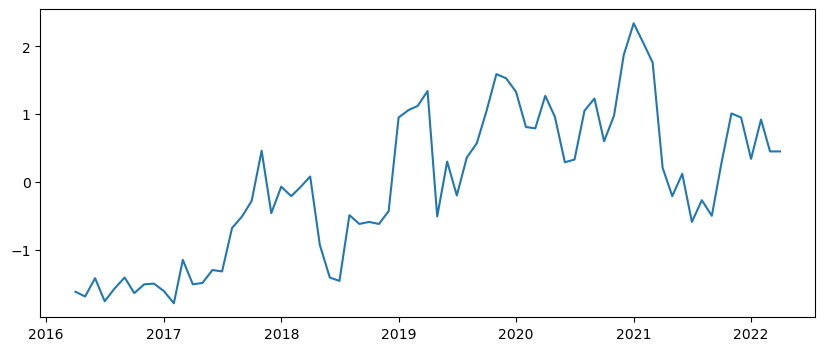

In [6]:
plt.clf()
plt.figure(figsize=(10, 4))
plt.plot(df_train['dates'][22],df_train['values'][22])
plt.show()

In [7]:
first_months = []
for i in range(len(df_train['id'])):
    first_months.append(df_train['dates'][i][0])
first_months = np.array(first_months).astype('datetime64[M]').astype(int) % 12 + 1

print(Counter(first_months).keys()) # equals to list(set(words))
print(Counter(first_months).values())

dict_keys([1, 5, 3, 4, 12, 2, 11, 7, 10, 8, 9, 6])
dict_values([50276, 2393, 3970, 3105, 1271, 8713, 1528, 1941, 1826, 1520, 1461, 1908])


Ряды, которые начинаются не с января дополняю слева средним значением.

In [8]:
for i in range(len(df_train['id'])):
    mean = np.array(df_train['values'][i]).mean()
    for j in range(df_train['dates'][i][0].astype('datetime64[M]').astype(int) % 12):
        df_train['values'][i].insert(0, mean)

In [9]:
len_sequences = []
for i in range(len(df_train['id'])):
    len_sequences.append(len(df_train['values'][i]))
pd.Series(len_sequences).describe()

count    79912.000000
mean        66.017357
std         14.749180
min         36.000000
25%         54.000000
50%         64.000000
75%         77.000000
max         97.000000
dtype: float64

Справа заполняю средним, чтобы размер всех рядов был 97

In [10]:
for i in range(len(df_train['id'])):
    mean = np.array(df_train['values'][i]).mean()
    add_length = 97 - len(df_train['values'][i])
    df_train['values'][i].extend([mean for i in range(add_length)])

<Figure size 640x480 with 0 Axes>

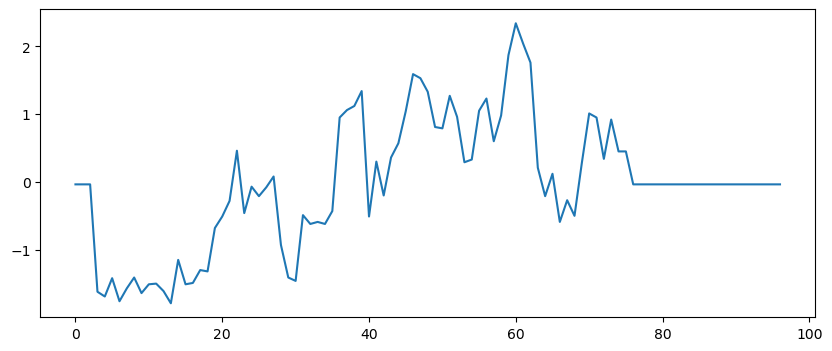

In [11]:
plt.clf()
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(df_train['values'][22])),df_train['values'][22])
plt.show()

In [12]:
X = []
y = []
for i in range(len(df_train['values'])):
    y.append((df_train['label'][i]))
    X.append((df_train['values'][i]))

In [13]:
X = np.array(X)
y = np.array(y)

Тренировка

In [14]:
from catboost import CatBoostClassifier

In [15]:
max_score_aucroc = 0.8216541790597093

In [16]:
print(Counter(y).keys()) # equals to list(set(words))
print(Counter(y).values())
print(57785/22127)

dict_keys([0.0, 1.0])
dict_values([57785, 22127])
2.6115153432458085


In [37]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = random.randint(1,100))
    params = {
        'iterations': 3500,
        #'learning_rate': 0.015,
        'depth': 9,
        'loss_function': 'Logloss',
        'eval_metric': 'PRAUC',
        'early_stopping_rounds': 80,
        'verbose': 700,
        'scale_pos_weight': 2.52 + 0.01 * i,
        'random_seed': 78 - i
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_test).T[1]

    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    
    if (auc(recall, precision) > max_score_aucroc):
        max_score_aucroc = auc(recall, precision)
        print("new record = ",max_score_aucroc)
        model.save_model('model_for_vk_v4')
    else:
        print(auc(recall, precision))

Learning rate set to 0.020272
0:	learn: 0.8026487	total: 212ms	remaining: 12m 22s
700:	learn: 0.9270083	total: 38.6s	remaining: 2m 34s
1400:	learn: 0.9647589	total: 1m 17s	remaining: 1m 56s
2100:	learn: 0.9830991	total: 1m 56s	remaining: 1m 17s
2800:	learn: 0.9923264	total: 2m 35s	remaining: 38.8s
3499:	learn: 0.9967254	total: 3m 14s	remaining: 0us
0.8022598029673503
Learning rate set to 0.020272
0:	learn: 0.8044344	total: 55.6ms	remaining: 3m 14s
700:	learn: 0.9266826	total: 39.4s	remaining: 2m 37s
1400:	learn: 0.9642366	total: 1m 19s	remaining: 1m 58s
2100:	learn: 0.9826634	total: 1m 58s	remaining: 1m 19s
2800:	learn: 0.9921440	total: 2m 38s	remaining: 39.5s
3499:	learn: 0.9966141	total: 3m 17s	remaining: 0us
0.8098761574924864
Learning rate set to 0.020272
0:	learn: 0.7971854	total: 57ms	remaining: 3m 19s
700:	learn: 0.9274271	total: 39.7s	remaining: 2m 38s
1400:	learn: 0.9646239	total: 1m 19s	remaining: 1m 58s
2100:	learn: 0.9830214	total: 1m 58s	remaining: 1m 19s
2800:	learn: 0.99

In [47]:
print(max_score_aucroc)

0.8254385035751735
